# Image Segmentation and Analysis Workflow

In this notebook, we will perform an image segmentation workflow on a set of biological images. The steps include setting up the software environment, developing an image segmentation workflow, extracting features from the segmented images, visualizing relationships between features, and determining feature correlations. This data has been cited as: "We used image set BBBC007v1 image set version 1 (Jones et al., Proc. ICCV Workshop on Computer Vision for Biomedical Image Applications, 2005), available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]."

### Steps to be performed

1. Import necessary libraries.
2. Load images and corresponding label images.
3. Perform image segmentation to produce label images.
4. Extract features from the segmented images.
5. Visualize relationships between the extracted features.
6. Find and visualize feature correlations.
7. Save results and perform quality assurance.

### Installation Instructions

To ensure a reproducible environment, please install the following packages using `pip`:
```
pip install numpy pandas scikit-image scipy matplotlib seaborn stackview
```
Or using `conda`:
```
conda install numpy pandas scikit-image scipy matplotlib seaborn stackview -c conda-forge
```

In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
from skimage import io, filters, measure
from scipy import ndimage as ndi
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
import seaborn as sns
import stackview


### Load images and corresponding label images

We will load all .tif images from the specified folders and store them in arrays for further processing.

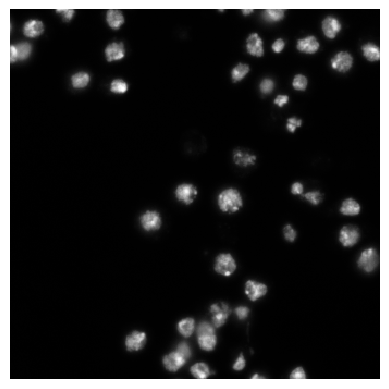

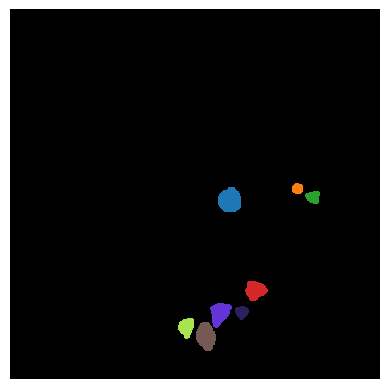

In [2]:
# Step 2: Load images and corresponding label images
image_folder = '../05b_quality_assurance/data/BBBC007_batch/'
label_folder = '../05b_quality_assurance/data/BBBC007_sparse_instance_annotation/'

image_files = [f for f in os.listdir(image_folder) if f.endswith('.tif')]
label_files = [f for f in os.listdir(label_folder) if f.endswith('.tif')]

images = [io.imread(os.path.join(image_folder, f)) for f in image_files]
labels = [io.imread(os.path.join(label_folder, f)) for f in label_files]

# Display the first image and its corresponding label
stackview.imshow(images[0])
stackview.imshow(labels[0])

### Perform image segmentation to produce label images

In this step, we will apply image thresholding, morphological operations, and other segmentation techniques to the images to produce labeled regions.

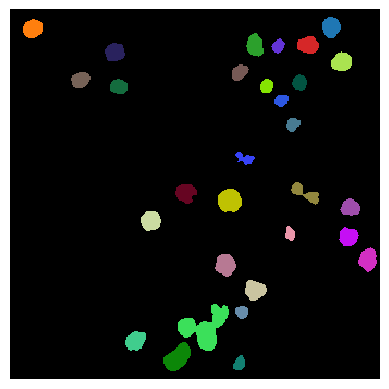

In [3]:
# Step 3: Image Segmentation
segmented_labels = []

for image in images:
    # Apply a Gaussian filter for smoothing
    smoothed_image = filters.gaussian(image, sigma=1)
    
    # Apply thresholding
    threshold_value = filters.threshold_otsu(smoothed_image)
    binary_image = smoothed_image > threshold_value
    
    # Remove artifacts connected to image border
    cleared_image = clear_border(binary_image)
    
    # Label image regions
    labeled_image, _ = ndi.label(cleared_image)
    segmented_labels.append(labeled_image)

    break # Display the first segmented result
stackview.imshow(segmented_labels[0])

### Extract features from the segmented images

We will extract several features such as area, perimeter, and shape-related properties from the segmented label images. These features will be stored in a DataFrame.

In [4]:
# Step 4: Extract features
features = []

for label_image in segmented_labels:
    properties = measure.regionprops_table(label_image, properties=['label', 'area', 'perimeter', 'eccentricity', 'solidity'])
    features.append(pd.DataFrame(properties))

features_df = pd.concat(features, ignore_index=True)
display(features_df)
# Save the extracted features
features_df.to_csv('extracted_features.csv', index=False)

,label,area,perimeter,eccentricity,solidity
0,1,261.0,58.284271,0.550108,0.963100
1,2,254.0,57.455844,0.467295,0.954887
2,3,253.0,59.698485,0.711364,0.940520
3,4,250.0,58.041631,0.637185,0.950570
4,5,116.0,38.870058,0.608680,0.943089
5,6,255.0,58.627417,0.409633,0.951493
6,7,266.0,58.870058,0.483817,0.963768
7,8,172.0,48.041631,0.705254,0.955556
8,9,208.0,52.627417,0.597989,0.941176
9,10,156.0,44.627417,0.291186,0.945455


### Visualize relationships between the extracted features

We will create pair plots to visualize the relationships between different features extracted from the images.

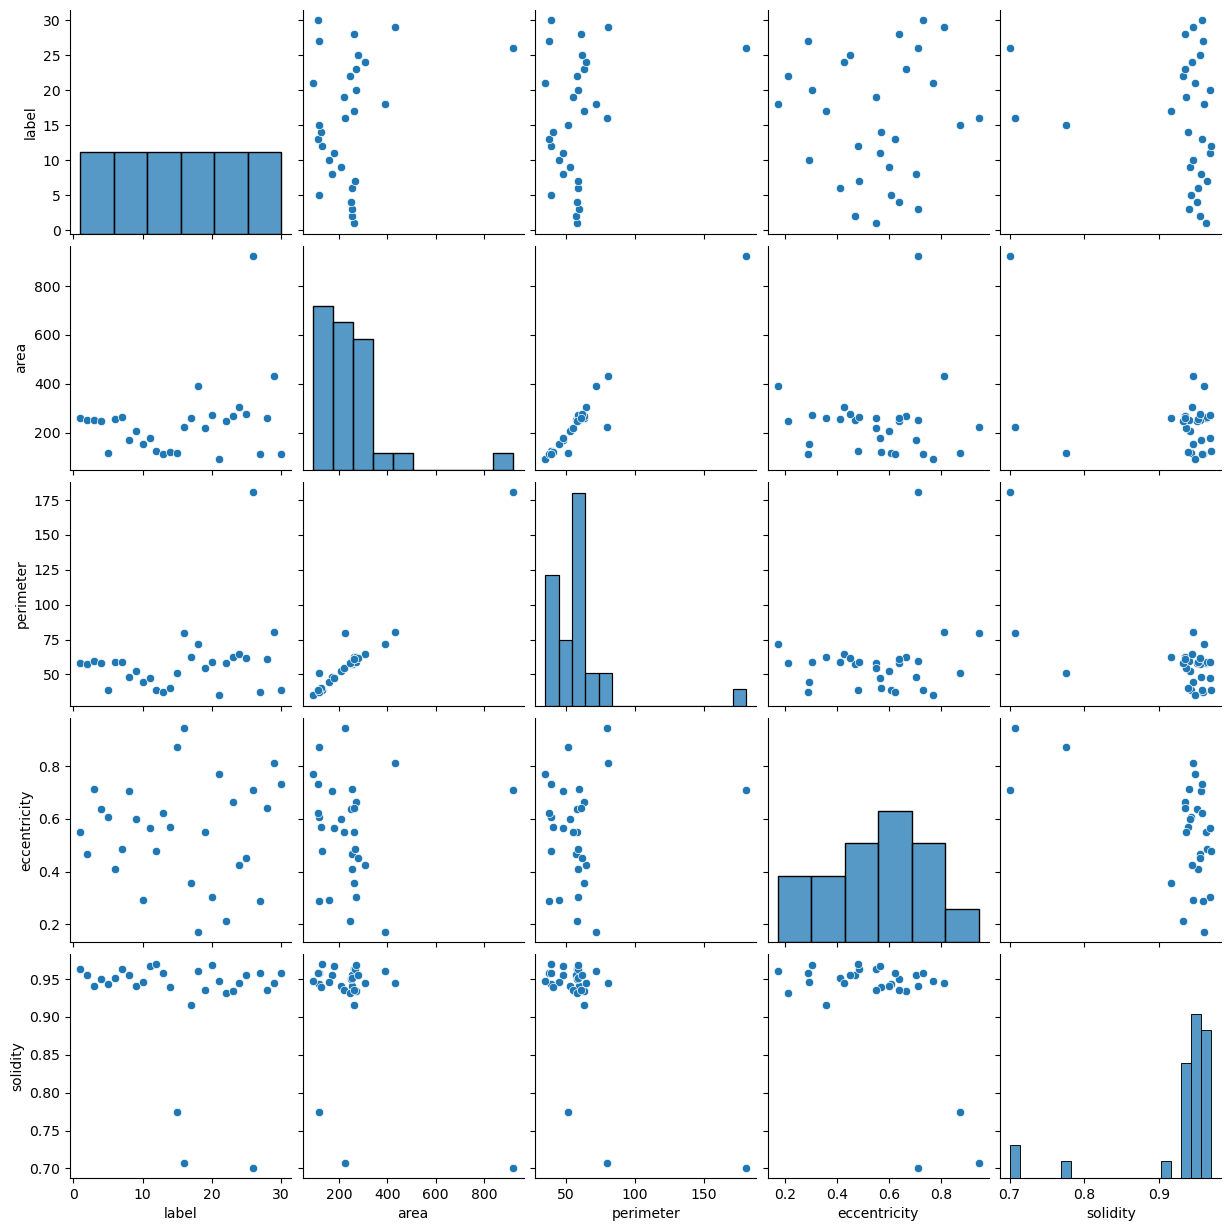

In [5]:
# Step 5: Visualize relationships
sns.pairplot(features_df)
plt.show()

### Find and visualize feature correlations

We will compute the correlation matrix for the extracted features and visualize it using a heatmap.

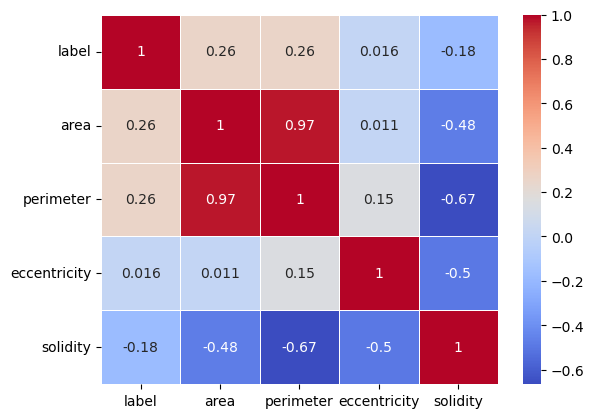

In [6]:
# Step 6: Find and visualize correlations
correlation_matrix = features_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

### Save results and perform quality assurance

We will save the extracted features as a CSV file and evaluate the segmentation quality using the sparse Jaccard index.

In [7]:
# Step 7: Save results and perform quality assurance
features_df.to_csv('extracted_features.csv', index=False)

# Evaluate segmentation quality
quality_scores = []

for ref, lbl in zip(labels, segmented_labels):
    jaccard_index = np.logical_and(ref, lbl).sum() / float(np.logical_or(ref, lbl).sum())
    quality_scores.append(jaccard_index)

quality_df = pd.DataFrame({'image': image_files, 'quality_score': quality_scores})
display(quality_df)
quality_df.to_csv('segmentation_quality.csv', index=False)

ValueError: All arrays must be of the same length

### Conclusion

In this notebook, we have performed image segmentation on a dataset of biological images, extracted relevant features, visualized relationships and correlations between these features, and evaluated the quality of our segmentation results. This workflow is designed to be extensible to similar datasets and aims to provide a comprehensive analysis of image data.